# **SSCS - Test Playground**

Developed by André Paiva

Based on SSCS Dataset created by Helena Cuesta and Emilia Gómez

## 01 - Import modules

In [1]:
import os
import json
import zipfile
import requests

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization

## 02 - Neural Network Model (VoasCNN)

In [4]:
SAVE_MODEL = True
LOAD_MODEL = True
SPLIT_SIZE = 128

In [5]:
def voas_cnn_model():
    x_in = Input(shape=(360, SPLIT_SIZE, 1))
    
    x = BatchNormalization()(x_in)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=32, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_1")(x)

    x = BatchNormalization()(x)

    x = Conv2D(filters=16, kernel_size=(70, 3), padding="same",
        activation="relu", name="conv_harm_2")(x)

    ## start four branches now

    x = BatchNormalization()(x)

    ## branch 1
    x1a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1a")(x)

    x1a = BatchNormalization()(x1a)

    x1b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv1b")(x1a)

    ## branch 2
    x2a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2a")(x)

    x2a = BatchNormalization()(x2a)

    x2b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv2b")(x2a)

    ## branch 3

    x3a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3a")(x)

    x3a = BatchNormalization()(x3a)

    x3b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv3b")(x3a)

    x4a = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4a")(x)

    x4a = BatchNormalization()(x4a)

    x4b = Conv2D(filters=16, kernel_size=(3, 3), padding="same",
        activation="relu", name="conv4b"
    )(x4a)


    y1 = Conv2D(filters=1, kernel_size=1, name='conv_soprano',
                padding='same', activation='sigmoid')(x1b)
    y1 = tf.squeeze(y1, axis=-1)
    y2 = Conv2D(filters=1, kernel_size=1, name='conv_alto',
                padding='same', activation='sigmoid')(x2b)
    y2 = tf.squeeze(y2, axis=-1)
    y3 = Conv2D(filters=1, kernel_size=1, name='conv_tenor',
                padding='same', activation='sigmoid')(x3b)
    y3 = tf.squeeze(y3, axis=-1)
    y4 = Conv2D(filters=1, kernel_size=1, name='conv_bass',
                padding='same', activation='sigmoid')(x4b)
    y4 = tf.squeeze(y4, axis=-1)

    out = [y1, y2, y3, y4]

    model = Model(inputs=x_in, outputs=out, name='voasCNN')

    return model

## 03 - Auxiliar functions

Functions designed to manipulate the SSCS dataset.

In [6]:
pathname = "Datasets"
zipname = pathname + "/SynthSalienceChoralSet_v1.zip"
splitname = pathname + "/SynthSalienceChoralSet_dataSplits.json"

In [7]:
def download(url, fname):
    
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    downloaded_size = 0
    with open(fname, 'wb') as file:
        for data in resp.iter_content(chunk_size=max(4096, int(total/10000))):
            size = file.write(data)
            downloaded_size += size
            percent = min(downloaded_size/total, 1.0)
            print(f"\r{percent:.2%} downloaded", end='')
    print()

In [8]:
def sscs_download():
    
    if(not os.path.exists(pathname)):
        os.mkdir(pathname)
   
    if(not os.path.exists(splitname)):
        print("Downloading SSCS Splits JSON...")
        url = "https://raw.githubusercontent.com/helenacuesta/voas-vocal-quartets/main/data/data_splits_hpc.json"
        download(url, splitname)
    else:
        print("SSCS Splits JSON found.")

    if(not os.path.exists(zipname)):
        print("Downloading SSCS Dataset...")
        url = "https://zenodo.org/record/6534429/files/SynthSalienceChoralSet_v1.zip?download=1"
        download(url, zipname)
    else:
        print("SSCS Dataset found.")

    print("Done.")

In [9]:
def sscs_read_metadata():
    
    with zipfile.ZipFile(zipname) as zf:
        with zf.open('sscs_metadata.csv') as f:
            df = pd.read_csv(f)
            return df

In [10]:
def sscs_read_voice(name, voice):
    
    filename = 'sscs/' + name + "_"
    if(voice.upper() == 'S' or voice.upper() == 'A' or \
       voice.upper() == 'T' or voice.upper() == 'B'):
        filename = filename + voice.upper()
    elif(voice.lower() == 'mix'):
        filename = filename + voice.lower()
    else:
        raise NameError("Specify voice with 'S', 'A', 'T', 'B' or 'mix'.")
    filename = filename + ".csv"
    with zipfile.ZipFile(zipname) as zf:
        with zf.open(filename) as f:
            df = pd.read_csv(f, header=None)
    return df

In [11]:
def sscs_read_all_voices(name):
    
    df_mix = sscs_read_voice(name, 'mix')
    df_sop = sscs_read_voice(name, 'S')
    df_alt = sscs_read_voice(name, 'A')
    df_ten = sscs_read_voice(name, 'T')
    df_bas = sscs_read_voice(name, 'B')
    return df_mix, df_sop, df_alt, df_ten, df_bas

In [12]:
def sscs_read_all_voice_splits(name, split_size):
    
    df_mix, df_sop, df_alt, df_ten, df_bas = sscs_read_all_voices(name)
    mix = np.array_split(df_mix, df_mix.shape[1]/split_size, axis=1)
    mix = np.array([i.iloc[:, :split_size] for i in mix])
    sop = np.array_split(df_sop, df_sop.shape[1]/split_size, axis=1)
    sop = np.array([i.iloc[:, :split_size] for i in sop])
    alt = np.array_split(df_alt, df_alt.shape[1]/split_size, axis=1)
    alt = np.array([i.iloc[:, :split_size] for i in alt])
    ten = np.array_split(df_ten, df_ten.shape[1]/split_size, axis=1)
    ten = np.array([i.iloc[:, :split_size] for i in ten])
    bas = np.array_split(df_bas, df_bas.shape[1]/split_size, axis=1)
    bas = np.array([i.iloc[:, :split_size] for i in bas])
    
    return mix, sop, alt, ten, bas

In [13]:
def sscs_get_split(split='train'):
    
    if(split.lower() == 'train' or split.lower() == 'validate' or
       split.lower() == 'test'):
        return json.load(open(splitname, 'r'))[split.lower()]
    else:
        raise NameError("Split should be 'train', 'validate' or 'test'.")

In [14]:
def sscs_pick_random_song(split='train'):
    
    songnames = sscs_get_split(split)
    rng = np.random.randint(0, len(songnames))
    return songnames[rng]

In [15]:
def sscs_plot(dataframe):

    aspect_ratio = (3/8)*dataframe.shape[1]/dataframe.shape[0]
    fig, ax = plt.subplots(figsize=(13, 7))
    im = ax.imshow(dataframe, interpolation='nearest', aspect=aspect_ratio,
        cmap = mpl.colormaps['BuPu'])
    ax.invert_yaxis()
    plt.show()

In [16]:
def sscs_plot_random(voice, split='train'):

    sscs_plot(sscs_read_voice(sscs_pick_random_song(split), voice))

## 04 - Download dataset SSCS

In [17]:
sscs_download()

SSCS Splits JSON found.
SSCS Dataset found.
Done.


## 05 - Pick random song and plot mix pitch saliences

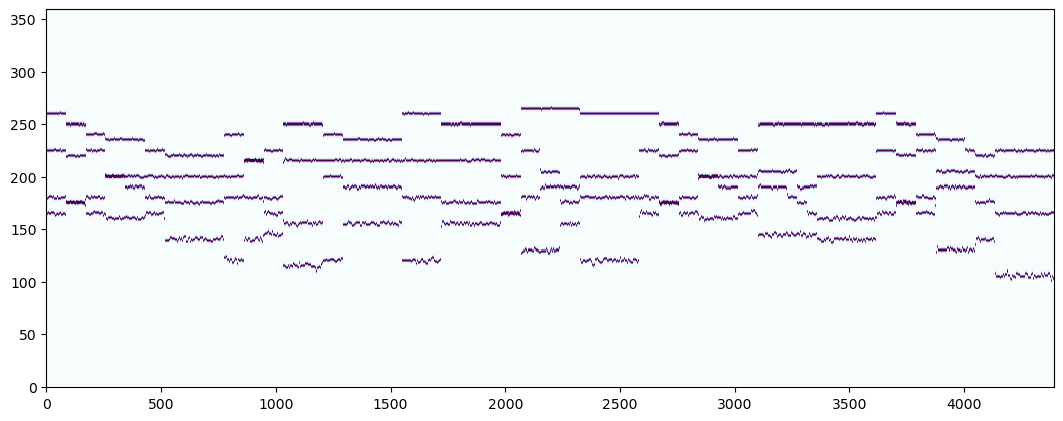

In [18]:
sscs_plot_random('mix')

## 06 - Getting data splits for training

In [19]:
mix = np.empty((0, 360, 128))
s = np.empty((0, 360, 128))
a = np.empty((0, 360, 128))
t = np.empty((0, 360, 128))
b = np.empty((0, 360, 128))

for i in range(5):
    mix_tmp, s_tmp, a_tmp, t_tmp, b_tmp = sscs_read_all_voice_splits(sscs_pick_random_song(), SPLIT_SIZE)
    mix = np.append(mix, mix_tmp, axis=0)
    s = np.append(s, s_tmp, axis=0)
    a = np.append(a, a_tmp, axis=0)
    t = np.append(t, t_tmp, axis=0)
    b = np.append(b, b_tmp, axis=0)

mix.shape

(1735, 360, 128)

In [20]:
'''
voas_cnn = voas_cnn_model()
voas_cnn.compile(optimizer=Adam(learning_rate=5e-3),
                 loss=BinaryCrossentropy(),
                 metrics=[Accuracy()])
'''

'\nvoas_cnn = voas_cnn_model()\nvoas_cnn.compile(optimizer=Adam(learning_rate=5e-3),\n                 loss=BinaryCrossentropy(),\n                 metrics=[Accuracy()])\n'